In [13]:
import numpy as np
import copy
import skimage 
from skimage.util import img_as_ubyte
from skimage import data
import rasterio as rs
from rasterio.merge import merge
from rasterio.plot import show
import hickle as hkl
import os
import scipy
from datetime import datetime
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append('../src/')
import utils.quick_viz as viz
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def remove_small_patches(arr, thresh):
    
    '''
    Label features in an array using ndimage.label()
    (option to add a 3x3 structure which considers features connected even 
    if they touch diagonally - probably dnt want this)
    
    '''
    start_unique, start_counts = np.unique(arr, return_counts=True)
    
    # creates arr where each unique feature (non zero value) has a unique label
    # num features are the number of connected patches
    labeled_array, num_features = ndimage.label(arr)

    # get pixel count for each label
    label_size = [(labeled_array == label).sum() for label in range(num_features + 1)]

    # if the count of pixels doesn't meet the threshold, make label 0
    for label,size in enumerate(label_size):
        if size < thresh:
            arr[labeled_array == label] = 0
            end_unique, end_counts = np.unique(arr, return_counts=True)
            
#     print(f'Start count: {dict(zip(start_unique, start_counts))}')
#     print(f'End count: {dict(zip(end_unique, end_counts))}')
    
    return arr

In [38]:
# import an array
raw_arr = rs.open('../tmp/ghana/preds/1648X1081Y_preds.tif').read(1)
unique, counts = np.unique(raw_arr, return_counts=True)
dict(zip(unique, counts))

{0: 93614, 1: 10634, 2: 275204}

In [39]:
# creates an array 
postprocess_mono = remove_small_patches(raw_arr == 1, thresh = 20)
postprocess_af = remove_small_patches(raw_arr == 2, thresh = 15)

Start count: {False: 368818, True: 10634}
End count: {False: 373370, True: 6082}
Start count: {False: 104248, True: 275204}
End count: {False: 105016, True: 274436}


In [41]:
# multiplying by boolean will turn every False into 0 
# and keep every True as the original label
raw_arr[raw_arr == 1] *= postprocess_mono[raw_arr == 1]
raw_arr[raw_arr == 2] *= postprocess_af[raw_arr == 2]
unique, counts = np.unique(raw_arr, return_counts=True)
dict(zip(unique, counts))

{0: 98934, 1: 6082, 2: 274436}

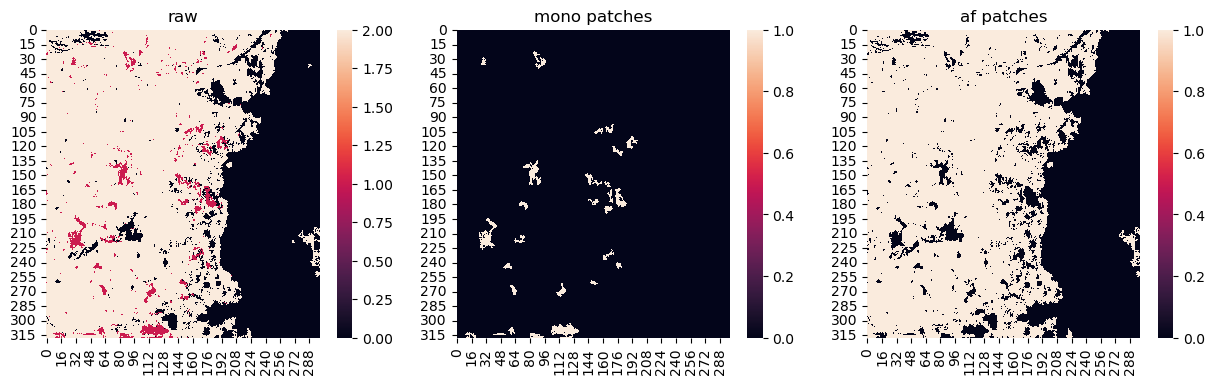

In [37]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.heatmap(raw_arr[300:, 200:500]).set_title('raw')
plt.subplot(1,3,2)
sns.heatmap(mono[300:, 200:500]).set_title('mono patches')
plt.subplot(1,3,3)
sns.heatmap(af[300:, 200:500]).set_title('af patches');

## Postprocessing Techniques for 4 classes

Approach 1: binary closing
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_closing.html

Approach 2: binary dilation + binary erosion
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_dilation.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_erosion.html

Approach 3: multiply by mask that is a median filter of the class

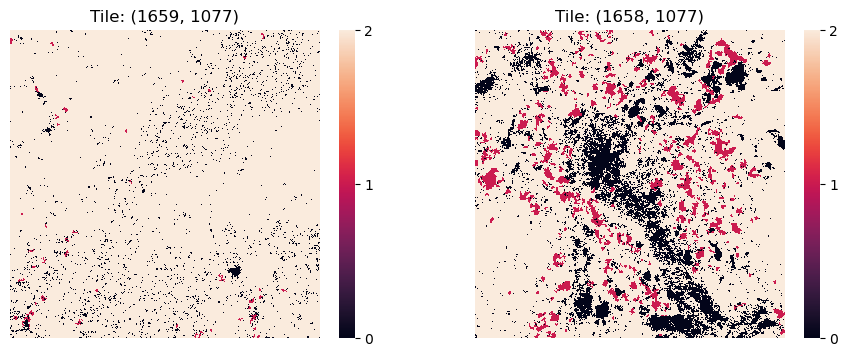

In [57]:
viz.heat_compare_preds('ghana', (1659,1077), (1658,1077))

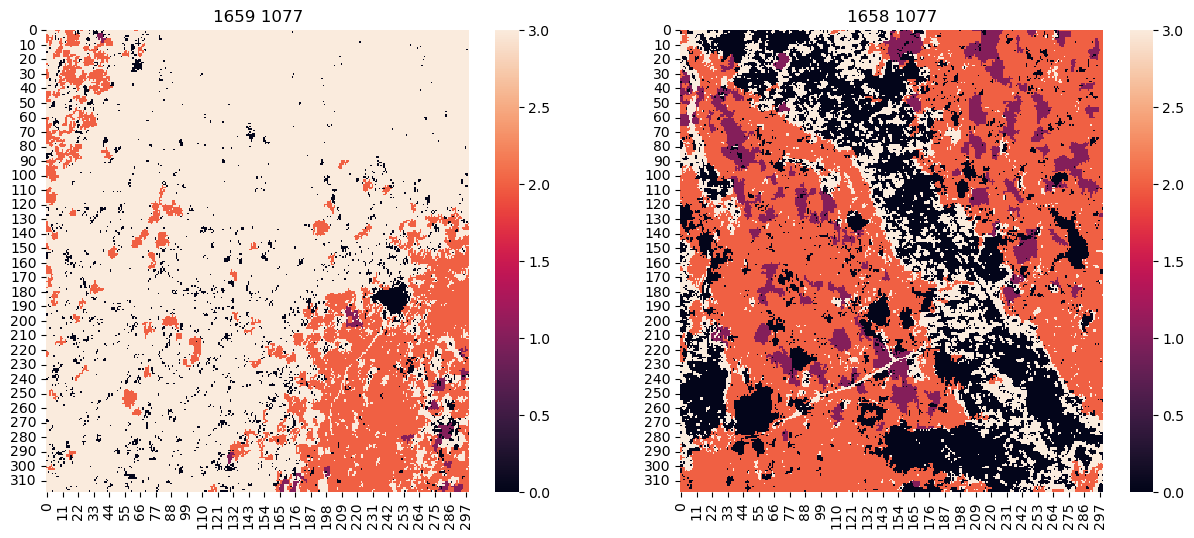

In [62]:
# import two prediction tiles to test the approach on
arr1 = rs.open('../tmp/ghana/preds/1659X1077Y_preds.tif').read(1)
arr2 = rs.open('../tmp/ghana/preds/1658X1077Y_preds.tif').read(1)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.heatmap(arr1[300:, 200:500]).set_title('1659 1077')
plt.subplot(1,2,2)
sns.heatmap(arr2[300:, 200:500]).set_title('1658 1077');

In [65]:
structuring_element = np.ones((3, 3), dtype=np.uint8)
closed1 = ndimage.binary_closing(arr1, structuring_element).astype(int)

In [67]:
np.unique(closed1, return_counts=True)

(array([0, 1]), array([  3393, 376059]))

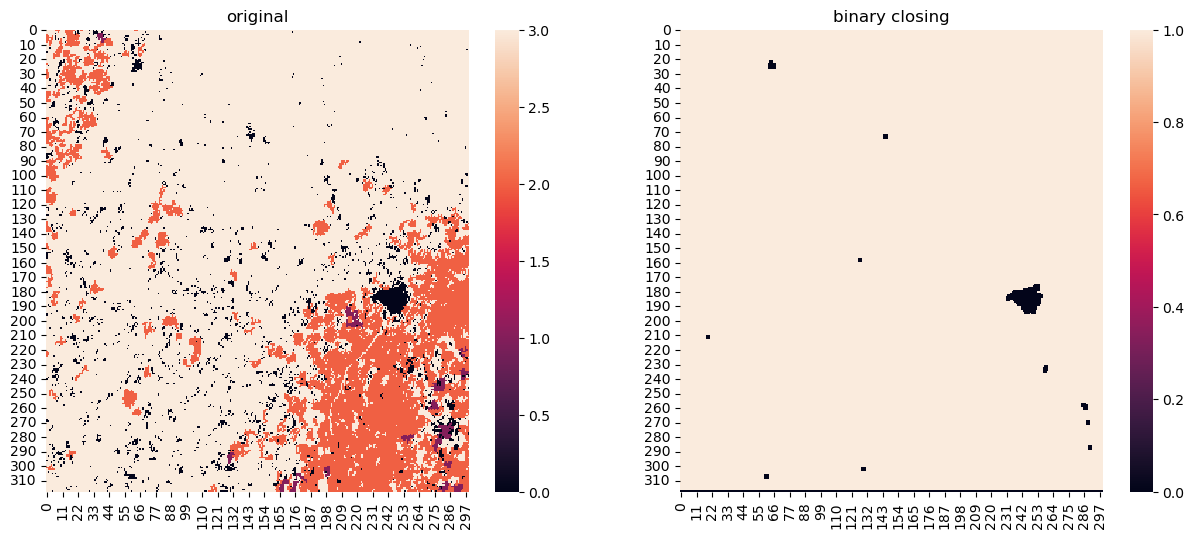

In [68]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.heatmap(arr1[300:, 200:500]).set_title('original')
plt.subplot(1,2,2)
sns.heatmap(closed1[300:, 200:500]).set_title('binary closing');

In [61]:
# Define a structuring element (a matrix that defines the neighborhood for the operation)

structuring_element

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

In [107]:
def load_ard(idx, subsample, directory = '../data/train-ard/'):
    '''
    Analysis ready data is stored as (12, 28, 28, 13) with 
    uint16 dtype, ranging from 0 - 65535 and ordered 
    Sentinel-2, DEM, Sentinel-1.
    
    Converts to float32, removes border information and
    calculates median of full array or random subsample.

    (12, 28, 28, 13)
    (28, 28, 13)
    (14, 14, 13) 
    '''
    ard = np.load(directory + str(idx) + '.npy')

    # checks for floating datatype, if not converts to float32
    if not isinstance(ard.flat[0], np.floating):
        assert np.max(ard) > 1
        ard = ard.astype(np.float32) / 65535
        assert np.max(ard) < 1

    # convert monthly images to annual median
    if subsample > 0:
        rng = np.arange(12)
        indices = np.random.choice(rng, subsample, replace=False)
        varied_median = np.zeros((subsample, ard.shape[1], ard.shape[2], ard.shape[3]))

        for x in range(subsample):
            for i in indices:
                varied_median[x, ...] = ard[i, ...]

        final_ard = np.median(varied_median, axis = 0)
        # does not save as float in order to use in texture analysis
        np.save(f'../data/train-ard-sub/{idx}.npy', final_ard)

    else:
        final_ard = np.median(ard, axis = 0)

    # slice out border information
    border_x = (final_ard.shape[0] - 14) // 2
    border_y = (final_ard.shape[1] - 14) // 2
    final_ard = final_ard[border_x:-border_x, border_y:-border_y, :].astype(np.float32)
        
    return final_ard

In [108]:
test = load_ard(20159, 4)

In [137]:
# load ard with subset and without subset
ard = p.load_ard('08001', subsample=0)

input ARD has dtype: uint16
input ARD has shape: (12, 28, 28, 13)
converted to dtype: float32
converted to shape: (12, 28, 28, 13)
Output ARD has dtype: float32
Output ARD has shape: (14, 14, 13)


In [138]:
sub = p.load_ard('08001', subsample=4)

input ARD has dtype: uint16
input ARD has shape: (12, 28, 28, 13)
converted to dtype: float32
converted to shape: (12, 28, 28, 13)
Subset med ARD saved w dtype: float32
Subset med ARD saved w shape: (28, 28, 13)
Output ARD has dtype: float32
Output ARD has shape: (14, 14, 13)


In [140]:
txt = p.load_txt('08001', use_ard=True)

Text input ARD has dtype: float32
Text input ARD has shape: (28, 28, 13)
Text ARD converted to dtype: float32
Text ARD converted to shape: (28, 28, 13)


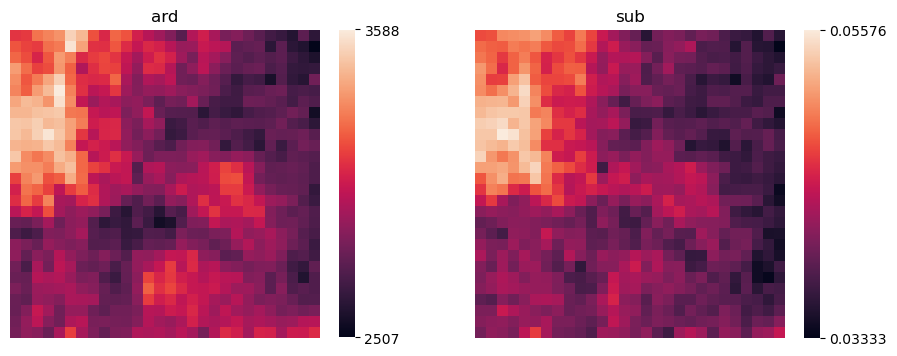

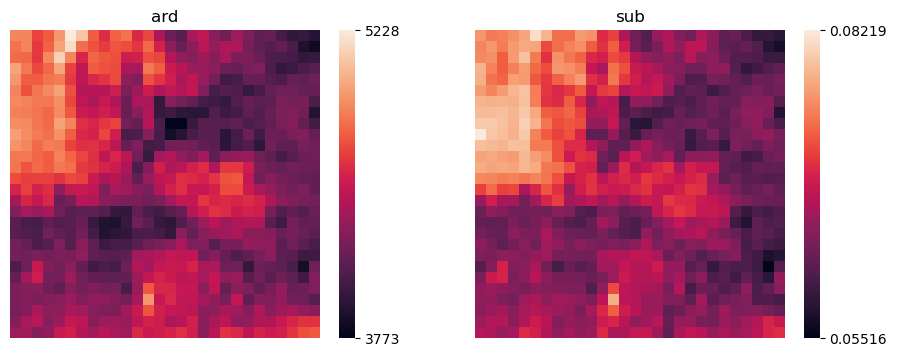

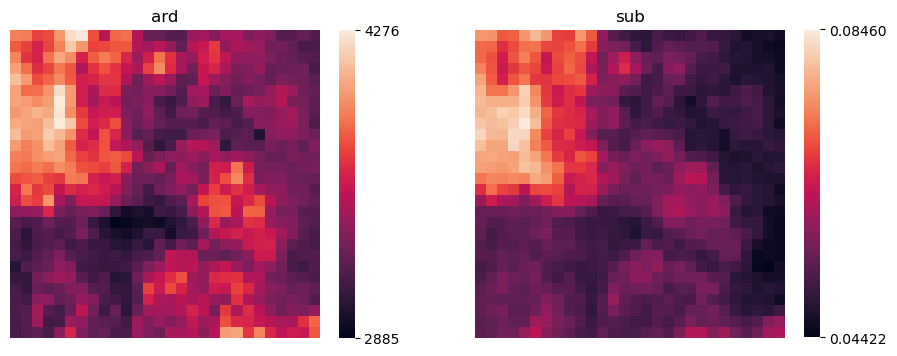

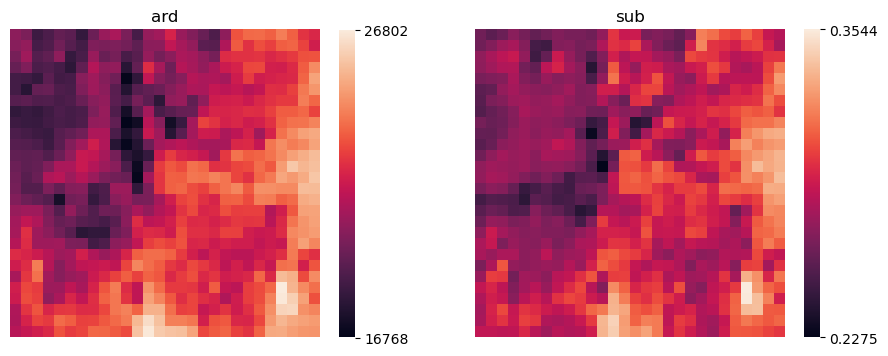

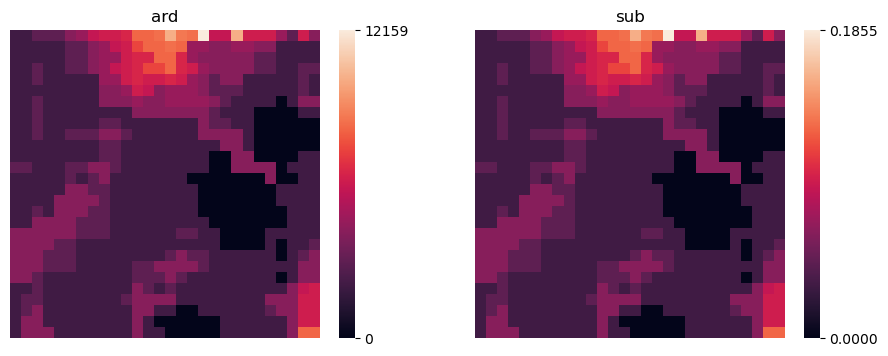

In [123]:
viz.heat_compare_arrays(ard[...,0], sub[...,0], 'ard', 'sub')
viz.heat_compare_arrays(ard[...,1], sub[...,1], 'ard', 'sub')
viz.heat_compare_arrays(ard[...,2], sub[...,2], 'ard', 'sub')
viz.heat_compare_arrays(ard[...,3], sub[...,3], 'ard', 'sub')
viz.heat_compare_arrays(ard[...,10], sub[...,10], 'ard', 'sub')

In [4]:
# review two texture tiles
# idx = '08011'
# tsub = np.load(f'../data/train-texture/{idx}_sub.npy')
# tard = np.load(f'../data/train-texture/{idx}_ard.npy')

# viz.heat_compare_arrays(tard[...,0], tsub[...,0], 'ard', 'sub')
# viz.heat_compare_arrays(tard[...,1], tsub[...,1], 'ard', 'sub')
# viz.heat_compare_arrays(tard[...,2], tsub[...,2], 'ard', 'sub')
# viz.heat_compare_arrays(tard[...,3], tsub[...,3], 'ard', 'sub')
# viz.heat_compare_arrays(tard[...,10], tsub[...,10], 'ard', 'sub')

In [150]:
idx = '08011'
arr_a = np.load(f'../data/train-texture/{idx}_sub.npy')
arr_b = np.load(f'../data/train-texture/{idx}_ard.npy')
arr_a = arr_a[...,0]
arr_b = arr_b[...,0]

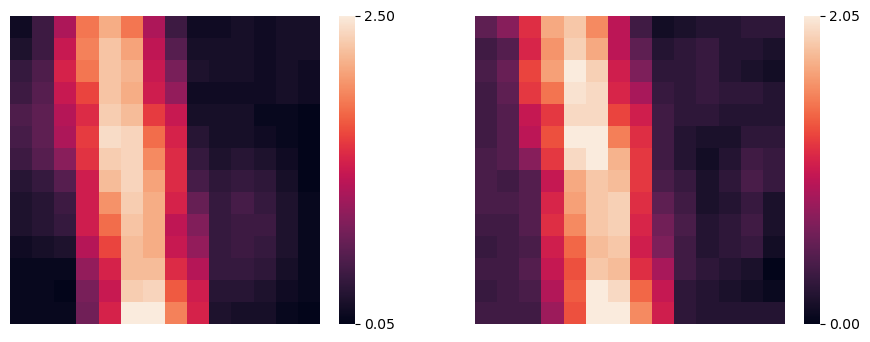

In [152]:
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
sns.heatmap(arr_a, 
            xticklabels=False, 
            yticklabels=False,
            cbar_kws = {'ticks' : [arr_a.min(), arr_a.max()]})

plt.subplot(1,2,2)
sns.heatmap(arr_b, 
            xticklabels=False, 
            yticklabels=False,
            cbar_kws = {'ticks' : [arr_b.min(), arr_b.max()]});

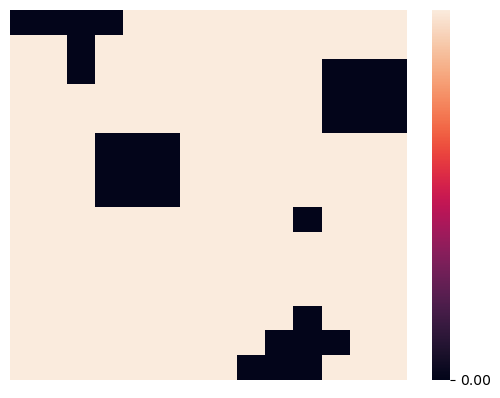

In [169]:
image = [[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],]

sns.heatmap(image, 
            xticklabels=False, 
            yticklabels=False,
            cbar_kws = {'ticks' : [arr_b.min(), arr_b.max()]});

In [176]:
# structure can't be larger than 3x3
structure = np.ones(shape=(14, 14))

In [177]:
# Label connected components
from scipy.ndimage import label

labeled, num_feats = label(image)

# sizes = ndi_sum(image, labeled, range(labeled.max() + 1))
# mask = np.isin(labeled, np.where(sizes > min_size)[0])
# filtered_image = image * mask

In [178]:
labeled

array([[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]], dtype=int32)

In [179]:
num_feats

1

In [182]:
label_size = [(labeled == label).sum() for label in range(num_feats + 1)]
label_size

[32, 178]

In [184]:


def cleanup_noisy_zeros2(preds, ttc_treecover):

    # creates boolean mask in areas where preds is 0 but tree cover is above 10
    is_fp_zero = np.logical_and(preds == 0, ttc_treecover > 10)
    preds_flt = ndimage.median_filter(np.copy(preds), 5)
    # replace all instances with filtered version of size 5
    preds[is_fp_zero] = preds_flt[is_fp_zero]
    # sets preds to 0 where tree cover is <10
    preds = preds * (ttc_treecover > 10)
    return preds

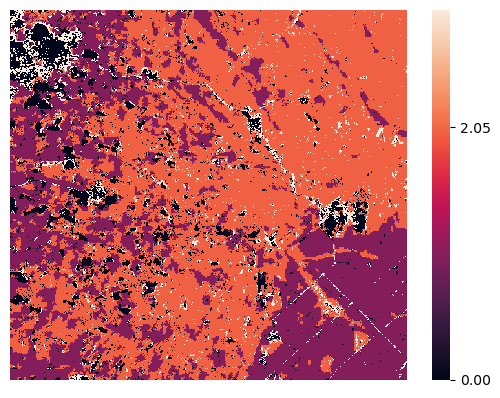

In [191]:
preds = rs.open('../tmp/ghana/preds/1668X1077Y_preds.tif').read(1)
sns.heatmap(preds, 
            xticklabels=False, 
            yticklabels=False,
            cbar_kws = {'ticks' : [arr_b.min(), arr_b.max()]});

In [17]:
# mosaic any x files

def mosaic_tif(location: list, version: str, tifs_to_mosaic: list):

    ''''
    Takes in a list of tiles from a csv file and 
    merges them to form a single tif.

    '''
    mosaic_dir = f'../tmp/{location[0]}/preds/mosaic/'
    reader_mode = []

    for file in tifs_to_mosaic:
        src = rs.open(f'{mosaic_dir}{file}')
        reader_mode.append(src) 

    print(f'Merging {len(reader_mode)} tifs.')

    mosaic, out_transform = merge(reader_mode, method='max')
    date = datetime.today().strftime('%Y-%m-%d')
    
    # outpath will be the new filename 
    outpath = f'{mosaic_dir}{location[1]}_{version}_{date}_mrgd.tif'
    out_meta = src.meta.copy()  
    out_meta.update({'driver': "GTiff",
                     'dtype': 'uint8',
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_transform,
                     'compress':'lzw',
                     'nodata': 255})

    with rs.open(outpath, "w", **out_meta) as dest:
        dest.write(mosaic)

    # Ensure to close all files
    for src in reader_mode:
        src.close()

    return None

In [18]:
mosaic_tif(['ghana', 'pd_east'], '25.5', ['pd_east1_v25.2_2024-04-29.tif',
                                          'pd_east2_v25.2_2024-04-29.tif',
                                          'pd_east3_v25.2_2024-04-29.tif',
                                          'pd_east4_v25.2_2024-04-29.tif'])

Merging 4 tifs.


In [14]:
## Why is the TTC filter not working over lakes?
## 1678, 1071

x = 1678
y = 1085
tile_str = f'{str(x)}X{str(y)}Y'
feats_raw = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/raw/feats/{tile_str}_feats.hkl').astype(np.float32)
feats_raw[0, ...] = feats_raw[0, ...] / 100 
feats_raw[1:, ...] = feats_raw[1:, ...] / 1000  
feats_rolled = np.rollaxis(feats_raw, 0, 3)
feats_rolled = np.rollaxis(feats_rolled, 0, 2)
ttc = copy.deepcopy(feats_rolled) 
high_feats = [np.arange(1,33)]
low_feats = [np.arange(33,65)]
ttc[:, :, [low_feats]] = feats_rolled[:, :, [high_feats]]
ttc[:, :, [high_feats]] = feats_rolled[:, :, [low_feats]]

In [16]:
ttc = ttc[:,:,0]
ttc

array([[0.91, 0.9 , 0.9 , ..., 0.  , 0.  , 0.  ],
       [0.91, 0.91, 0.92, ..., 0.  , 0.  , 0.  ],
       [0.92, 0.93, 0.94, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float32)

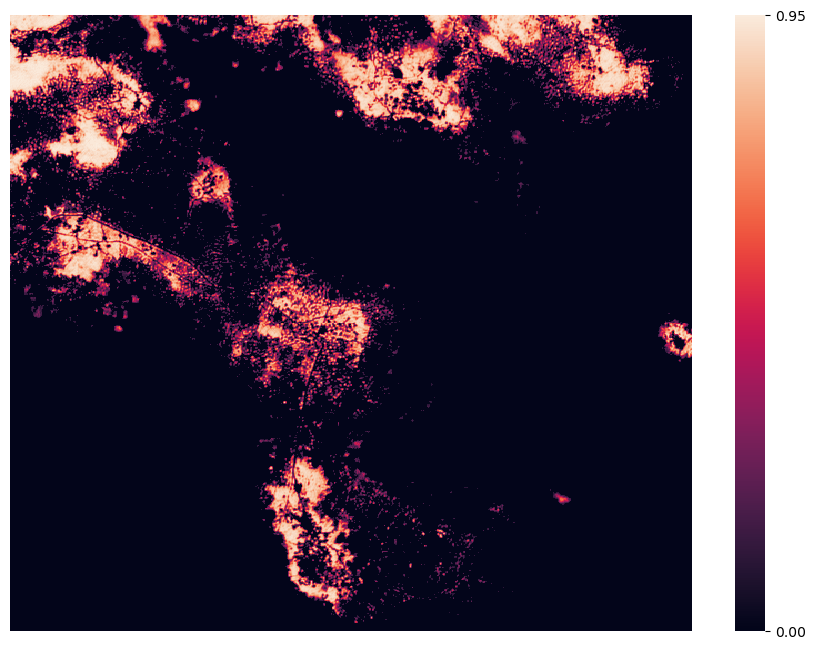

In [20]:

plt.figure(figsize=(11,8))

sns.heatmap(ttc, 
            xticklabels=False, 
            yticklabels=False,
            cbar_kws = {'ticks' : [ttc.min(), ttc.max()]});